In [2]:
import nibabel as nib
import os
import numpy as np
import os.path as op
import scipy
import pandas as pd
import pickle
import scipy.stats
from ipyparallel import Client
from statsmodels.formula.api import ols
import statsmodels.api as sm 
import statsmodels.formula.api as smf
from sklearn import manifold
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests, fdrcorrection


#classification
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing, metrics, feature_selection, decomposition
from sklearn.model_selection import cross_val_score, LeaveOneGroupOut
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
%matplotlib inline


/home/iballard/anaconda/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/iballard/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [6]:
rc = Client()

In [3]:
#preliminary housekeeping
home_dir = '/data/home/iballard/fd/'
subj_file = home_dir + 'subjects.txt'
subs = list(np.loadtxt(subj_file,'string'))
os.chdir(home_dir)

In [23]:
def get_matching_cond(run,cond):
    if cond in ['b_plus','c_minus']:
        conj = 'double'
    else:
        conj = 'single'
    
    if run == 1:
        if cond in ['b_plus','b_minus']:
            stim = 'face'
            ctrl = 'body'
        else:
            stim = 'body'
            ctrl = 'face'
    elif run == 2:
        if cond in ['b_plus','b_minus']:
            stim = 'body'
            ctrl = 'place'
        else:
            stim = 'place'
            ctrl = 'body'
    elif run == 3:
        if cond in ['b_plus','b_minus']:
            stim = 'place'
            ctrl = 'face'
        else:
            stim = 'face'
            ctrl = 'place'
                
    return stim, conj, ctrl


In [32]:
smooth = 'smoothed'
similarity_df = {'mask':[],'sub':[],'run':[],'condition':[],'corr':[],'conjunction':[],'target_stim':[]}
for m in ['hipp','peri_sim','para_sim']:
    for sub in subs:

        #load loc betas and take mean across trials
        out_f = op.join(home_dir,'betas','whitened', '_'.join(['loc-betas',sub,smooth,m]) + '.csv')
        betas = pd.read_csv(out_f)
        template = betas.groupby(['condition','voxel']).mean()
 
        #load sim betas and organize by trial
        out_f = op.join(home_dir,'betas','whitened', '_'.join(['sim_4mm-betas',sub,smooth,m]) + '.csv')
        sim_betas = pd.read_csv(out_f)
        sim_betas = sim_betas.set_index(['run','condition','trial'])

        #compute correlation with template
        for run, cond, trial in set(sim_betas.index):
            stim, conj, ctrl = get_matching_cond(int(run),cond)
            corr = scipy.stats.pearsonr(sim_betas.loc[(run,cond,trial),'value'].values,
                                        template.loc[stim,'value'].values)[0]

            baseline = scipy.stats.pearsonr(sim_betas.loc[(run,cond,trial),'value'].values,
                                        template.loc[ctrl,'value'].values)[0]
            corr = corr #- baseline
            
            #log results
            similarity_df['sub'].append(sub)
            similarity_df['run'].append(run)
            similarity_df['mask'].append(m)
            similarity_df['condition'].append(cond)
            similarity_df['corr'].append(corr)
            similarity_df['conjunction'].append(conj)
            similarity_df['target_stim'].append(stim)


similarity_df = pd.DataFrame(similarity_df)

In [39]:
similarity_df.to_csv('/home/iballard/Dropbox/fd/paper/data/localizer_similarity.csv',index = False)

reg_map = {'hipp':'Hippocampus','para_sim':'PHc', 'peri_sim':'PRc','yeo17_ifs':'IFS',
           'mOFC_fill_sim':'mOFC'}
similarity_df['roi'] = [reg_map[x] for x in similarity_df['mask']]

In [98]:
model_str = 'corr ~ conjunction*mask'
mixedfx = smf.mixedlm(model_str, similarity_df, groups = similarity_df['sub'], re_formula = '~mask').fit()
mixedfx.summary()

/home/iballard/anaconda/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Mixed Linear Model Regression Results
====================================================================================
Model:                      MixedLM          Dependent Variable:          corr      
No. Observations:           11280            Method:                      REML      
No. Groups:                 32               Scale:                       0.0035    
Min. group size:            240              Likelihood:                  15821.3824
Max. group size:            360              Converged:                   Yes       
Mean group size:            352.5                                                   
------------------------------------------------------------------------------------
                                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------
Intercept                                 -0.003    0.001 -2.287 0.022 -0.006 -0.000
conjunction[T.single]                      0.005    0.002  2.621 0.009  0.001  0.009
mask[T.para_sim]                           0.008    0.002  4.121 0.000  0.004  0.012
mask[T.peri_sim]                           0.005    0.002  2.122 0.034  0.000  0.009
conjunction[T.single]:mask[T.para_sim]    -0.007    0.003 -2.395 0.017 -0.012 -0.001
conjunction[T.single]:mask[T.peri_sim]    -0.006    0.003 -2.364 0.018 -0.012 -0.001
Intercept RE                               0.000    0.000                           
Intercept RE x mask[T.para_sim] RE         0.000    0.000                           
mask[T.para_sim] RE                        0.000    0.000                           
Intercept RE x mask[T.peri_sim] RE        -0.000    0.000                           
mask[T.para_sim] RE x mask[T.peri_sim] RE  0.000    0.000                           
mask[T.peri_sim] RE                        0.000    0.000                           
====================================================================================

"""

In [101]:
model_str = 'corr ~ conjunction*mask'
mixedfx = smf.mixedlm(model_str, similarity_df, groups = similarity_df['sub'], re_formula = '~mask').fit()
mixedfx.summary()

/home/iballard/anaconda/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Mixed Linear Model Regression Results
====================================================================================
Model:                      MixedLM          Dependent Variable:          corr      
No. Observations:           11280            Method:                      REML      
No. Groups:                 32               Scale:                       0.0029    
Min. group size:            240              Likelihood:                  16860.6215
Max. group size:            360              Converged:                   Yes       
Mean group size:            352.5                                                   
------------------------------------------------------------------------------------
                                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------
Intercept                                  0.001    0.003  0.180 0.857 -0.005  0.006
conjunction[T.single]                      0.003    0.002  1.885 0.059 -0.000  0.007
mask[T.para_sim]                           0.020    0.005  4.110 0.000  0.011  0.030
mask[T.peri_sim]                           0.013    0.004  2.826 0.005  0.004  0.021
conjunction[T.single]:mask[T.para_sim]    -0.006    0.002 -2.231 0.026 -0.010 -0.001
conjunction[T.single]:mask[T.peri_sim]    -0.006    0.002 -2.619 0.009 -0.011 -0.002
Intercept RE                               0.000    0.001                           
Intercept RE x mask[T.para_sim] RE        -0.000    0.002                           
mask[T.para_sim] RE                        0.001    0.004                           
Intercept RE x mask[T.peri_sim] RE        -0.000    0.002                           
mask[T.para_sim] RE x mask[T.peri_sim] RE  0.000    0.002                           
mask[T.peri_sim] RE                        0.001    0.003                           
====================================================================================

"""

In [108]:
hipp = similarity_df[similarity_df['roi'] == 'PHc']

model_str = 'corr ~ conjunction'
mixedfx = smf.mixedlm(model_str, hipp, groups = hipp['sub']).fit()   
print mixedfx.tvalues
print mixedfx.conf_int()
e = mixedfx.bse_fe['conjunction[T.single]']
print 'pe',mixedfx.params['conjunction[T.single]']
print 'dz',mixedfx.params['conjunction[T.single]'] / (e * np.sqrt(len(subs)))
print mixedfx.summary()


/home/iballard/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/iballard/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/iballard/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/iballard/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Intercept                3.123347
conjunction[T.single]   -0.710110
groups RE                0.522062
dtype: float64
                              0         1
Intercept              0.001780  0.007780
conjunction[T.single] -0.005566  0.002606
groups RE             -0.003624  0.006256
pe -0.00148037207151
dz -0.125530884679
              Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    corr     
No. Observations:    3760       Method:                REML     
No. Groups:          32         Scale:                 0.0041   
Min. group size:     80         Likelihood:            4993.0633
Max. group size:     120        Converged:             No       
Mean group size:     117.5                                      
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.005    0.002 

/home/iballard/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/iballard/anaconda/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2001: ConvergenceWarning: Gradient optimization failed.
  warnings.warn(msg, ConvergenceWarning)
/home/iballard/anaconda/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [104]:
import moss
similarity_df = moss.remove_unit_variance(similarity_df, 'corr', 'sub', group='mask', suffix="_within")

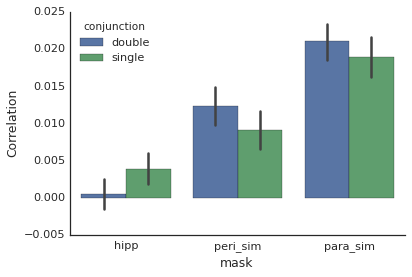

In [105]:
sns.set(rc={"figure.figsize": (6, 4)})
sns.set_context('paper',font_scale = 1.4)
sns.set_style("white")


sns.barplot(x = 'mask',y = 'corr_within',hue = 'conjunction',data = similarity_df)
sns.despine()
plt.ylabel('Correlation')
# plt.xlabel('Behavioral Leakiness')
plt.savefig('/home/iballard/Dropbox/fd/figs/paper/loc_evidence_baseline.png', dpi = 300)

# Boostrap analysis

In [19]:
def run_bootstrap(in_tuple):
    sub, m, n_iters =  in_tuple
    out_f = op.join(home_dir,'loc_bootstrap','_'.join([sub,m]) +'.csv')
    smooth = 'smoothed'
    
    similarity_df = {'mask':[],'sub':[],'condition':[],'run':[],'iter':[],'corr':[],'conjunction':[]}

    #load loc betas and take mean across trials
    in_f = op.join(home_dir,'betas','whitened', '_'.join(['loc-betas',sub,smooth,m]) + '.csv')
    betas = pd.read_csv(in_f)
    template = betas.groupby(['condition','voxel']).mean().sort_index()

    #load sim betas and organize by trial
    in_f = op.join(home_dir,'betas','whitened', '_'.join(['sim_4mm-betas',sub,smooth,m]) + '.csv')
    sim_betas = pd.read_csv(in_f)
    sim_betas = sim_betas.set_index(['run','condition','trial']).sort_index()

    for n in range(n_iters):
        #compute correlation with template
        for run, cond, trial in set(sim_betas.index):
            stim, conj, ctrl = get_matching_cond(int(run),cond)
            template_pattern = template.loc[stim,'value'].values
            np.random.shuffle(template_pattern)
            corr = scipy.stats.pearsonr(sim_betas.loc[(run,cond,trial),'value'].values,
                                        template_pattern)[0]

            #log results
            similarity_df['sub'].append(sub)
            similarity_df['mask'].append(m)
            similarity_df['condition'].append(cond)
            similarity_df['run'].append(run)
            similarity_df['corr'].append(corr)
            similarity_df['conjunction'].append(conj)
            similarity_df['iter'].append(n)

    similarity_df = pd.DataFrame(similarity_df)
    similarity_df = similarity_df.groupby(['sub','run','iter','conjunction','mask']).mean().reset_index()

    similarity_df.to_csv(out_f, index = False)

In [20]:
in_tuples = []
n_iters = 10000
for sub in subs:
    for m in ['hipp','peri_sim','para_sim']:
        in_tuples.append((sub,m,n_iters))

In [21]:
import multiprocessing
pool = multiprocessing.Pool(54)
res = pool.map(run_bootstrap,in_tuples)
pool.terminate()
pool.join()

In [28]:
samples = []
for sub in subs:
    for m in ['hipp','peri_sim','para_sim']:
        in_f = op.join(home_dir,'loc_bootstrap','_'.join([sub,m]) +'.csv')
        data = pd.read_csv(in_f)
        samples.append(data)
samples = pd.concat(samples)
samples = samples.groupby(['mask','conjunction','iter']).mean().reset_index()

In [35]:
roi_names = {'para_sim':'PHc',
             'peri_sim':'PRc',
             'hipp':'Hippocampus'}
samples['roi'] = [roi_names[x] for x in samples['mask']]
similarity_df['roi'] = [roi_names[x] for x in similarity_df['mask']]

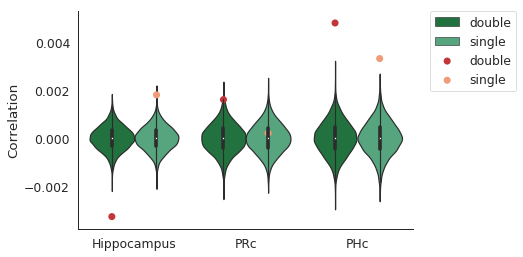

In [31]:
ax = sns.violinplot(x = 'roi',y= 'corr',
                    hue = 'conjunction',
                    data = samples,
               palette = sns.color_palette("BuGn_r",n_colors = 4))

sns.pointplot(x = 'roi',y = 'corr',
              hue = 'conjunction',
              data = similarity_df,
              palette = sns.color_palette("RdBu", n_colors=6),
              dodge = .4,
              ci = None,
              join = False, ax = ax)
sns.despine()
plt.ylabel('Correlation')
plt.xlabel('')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('/home/iballard/Dropbox/fd/figs/paper/reactivation_permuation.png', 
            dpi = 300,
           bbox_inches = 'tight')
sns.set_style({'font.family': 'Times New Roman'})

In [ ]:
s = similarity_df.groupby(['mask', 'conjunction']).mean()
samp = samples.set_index(['mask','conjunction'])
val = s.loc[('hipp','single'),'corr'] - s.loc[('hipp','double'),'corr']
shuffled_differences = samp.loc[('hipp','single'),'corr'].values - samp.loc[('hipp','double'),'corr'].values
print 'hipp diff' ,1 - sum(val > shuffled_differences)/10000.0


peri_val = val - (s.loc[('peri_sim','single'),'corr'] - s.loc[('peri_sim','double'),'corr'])
peri_diff = samp.loc[('peri_sim','single'),'corr'].values - samp.loc[('peri_sim','double'),'corr'].values
peri_diff = peri_diff - shuffled_differences
print 'peri conjunction', 1 - sum(peri_val > peri_diff)/10000.0

peri_val = val - (s.loc[('para_sim','single'),'corr'] - s.loc[('para_sim','double'),'corr'])
peri_diff = samp.loc[('para_sim','single'),'corr'].values - samp.loc[('para_sim','double'),'corr'].values
peri_diff = peri_diff - shuffled_differences
print 'para conjunction', 1 - sum(peri_val > peri_diff)/10000.0

In [60]:
#average difference across trial typess
s = similarity_df.groupby(['mask']).mean()
samp = samples.groupby(['iter','mask']).mean().reset_index().set_index(['mask'])

val = s.loc['hipp','corr'] - s.loc['peri_sim','corr']
peri_diff = samp.loc['hipp','corr'] -  samp.loc['peri_sim','corr']
print sum(val < peri_diff)/10000.0

val = s.loc['hipp','corr'] - s.loc['para_sim','corr']
peri_diff = samp.loc['hipp','corr'] -  samp.loc['para_sim','corr']
print sum(val < peri_diff)/10000.0


0.0
0.0


In [136]:
d = similarity_df.groupby(['conjunction','mask']).mean()
s = samples.set_index((['conjunction','mask']))
for row in set(d.index):
    val = d.loc[row,'corr']
    shuff = s.loc[row,'corr']
    print row, sum(shuff > val)/float(len(shuff))
    

('single', 'peri_sim') 0.3834
('double', 'peri_sim') 0.0091
('double', 'hipp') 1.0
('single', 'hipp') 0.0002
('single', 'para_sim') 0.0
('double', 'para_sim') 0.0


In [109]:
fdrcorrection([.0001,.0001,.0001,.0001,.0001,.1161],.05)

(array([ True,  True,  True,  True,  True, False], dtype=bool),
 array([ 0.00012,  0.00012,  0.00012,  0.00012,  0.00012,  0.1161 ]))

# Sort template similarity by visual content

Text(0.5,0,'')

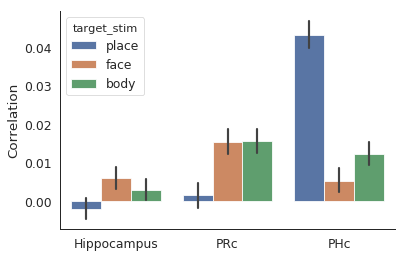

In [36]:
sns.set(rc={"figure.figsize": (6, 4)})
sns.set_context('paper',font_scale = 1.4)
sns.set_style("white")
sns.barplot(x = 'roi', y = 'corr', hue = 'target_stim', data = similarity_df)
sns.despine()
plt.ylabel('Correlation')
plt.xlabel('')
# plt.savefig('/home/iballard/Dropbox/fd/figs/paper/loc_categorical.png', dpi = 300)

In [80]:
hipp = similarity_df[similarity_df['roi'] == 'ParaHipp']

model_str = 'corr ~ C(target_stim, Sum)'
mixedfx = smf.mixedlm(model_str, hipp, groups = hipp['sub']).fit()   

mixedfx.summary()

/home/iballard/anaconda/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
=======================================================================
Model:                  MixedLM      Dependent Variable:      corr     
No. Observations:       3760         Method:                  REML     
No. Groups:             32           Scale:                   0.0029   
Min. group size:        80           Likelihood:              5599.3487
Max. group size:        120          Converged:               Yes      
Mean group size:        117.5                                          
-----------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                    0.020    0.005   4.165 0.000  0.011  0.029
C(target_stim, Sum)[S.body] -0.008    0.001  -6.380 0.000 -0.010 -0.005
C(target_stim, Sum)[S.face] -0.015    0.001 -12.040 0.000 -0.017 -0.012
groups RE                    0.001    0.004                            
=======================================================================

"""